In [1]:
# Limitasi Synchronous:
# ---------------------------------
# Audio Maximum 1 Menit
# Audio Maximum 10 MB
# ---------------------------------

# Import Library
from google.cloud.speech_v2 import SpeechClient
from google.cloud.speech_v2.types import cloud_speech
from google.oauth2 import service_account


# Function transkrip audio Synchronous
def transcribe_file_v2(project_id: str, audio_file: str) -> cloud_speech.RecognizeResponse:
    # Instantiates client
    credentials = service_account.Credentials.from_service_account_file('gcloud_apikey.json')
    client = SpeechClient(credentials=credentials)

    # Baca file dalam bytes
    with open(audio_file, "rb") as f:
        content = f.read()

    # Config untuk speech recognition
    config = cloud_speech.RecognitionConfig(
        auto_decoding_config=cloud_speech.AutoDetectDecodingConfig(),
        language_codes=["en-US"],
        model="long",
    )

    # Membentuk objek request
    request = cloud_speech.RecognizeRequest(
        recognizer=f"projects/{project_id}/locations/global/recognizers/_",
        config=config,
        content=content,
    )

    # Transkrip audio menjadi teks
    response = client.recognize(request=request)

    # Print respon transkrip
    for result in response.results:
        print(f"Transcript: {result.alternatives[0].transcript}")

    # Return respon transkrip
    return response

In [2]:
%%HTML
<video width="500" controls>
    <source src="speech_data/Donald Trump.mp4" type="video/mp4">
    <track src="Anime.srt" kind="subtitles">
</video>

In [3]:
# Import Library
from moviepy.editor import VideoFileClip

# Deklarasi input dan output
mp4_file = "speech_data/Donald Trump.mp4"
mp3_file = "speech_data/Donald Trump.mp3"

# Load video
video_clip = VideoFileClip(mp4_file)

# Ekstrak audio dari video
audio_clip = video_clip.audio

# Simpan audio ke file
audio_clip.write_audiofile(mp3_file)

# Menutup file audio dan video
audio_clip.close()
video_clip.close()

MoviePy - Writing audio in speech_data/Donald Trump.mp3


MoviePy - Done.


In [4]:
## Menyimpan Hasil Transkrip
hasil_transkrip = transcribe_file_v2(
    project_id='data-science-programming-ti24',
    audio_file=mp3_file)

Transcript: when I'm back in the White House America's enemies will now once again
Transcript:  and they're going to know it
Transcript:  that if you try to
Transcript:  kill our citizens we will kill you we will kill you
Transcript:  I told them all that we had no problem
Transcript:  you know we had no problem three years ago we had no problem for four years nobody even this is Unthinkable I mean I just watch and see what's happening it's Unthinkable this couldn't have happened


In [5]:
print(hasil_transkrip)

results {
  alternatives {
    transcript: "when I\'m back in the White House America\'s enemies will now once again"
    confidence: 0.975373626
  }
  result_end_offset {
    seconds: 4
    nanos: 600000000
  }
  language_code: "en-US"
}
results {
  alternatives {
    transcript: " and they\'re going to know it"
    confidence: 0.851483166
  }
  result_end_offset {
    seconds: 6
    nanos: 250000000
  }
  language_code: "en-US"
}
results {
  alternatives {
    transcript: " that if you try to"
    confidence: 0.977684855
  }
  result_end_offset {
    seconds: 9
    nanos: 280000000
  }
  language_code: "en-US"
}
results {
  alternatives {
    transcript: " kill our citizens we will kill you we will kill you"
    confidence: 0.991121471
  }
  result_end_offset {
    seconds: 13
    nanos: 850000000
  }
  language_code: "en-US"
}
results {
  alternatives {
    transcript: " I told them all that we had no problem"
    confidence: 0.977864921
  }
  result_end_offset {
    seconds: 17
   

In [6]:
list_hasil_transkrip = list()

for hasil in hasil_transkrip.results:
    teks = f'{hasil.alternatives[0].transcript}'
    list_hasil_transkrip.append(teks)

list_hasil_transkrip

["when I'm back in the White House America's enemies will now once again",
 " and they're going to know it",
 ' that if you try to',
 ' kill our citizens we will kill you we will kill you',
 ' I told them all that we had no problem',
 " you know we had no problem three years ago we had no problem for four years nobody even this is Unthinkable I mean I just watch and see what's happening it's Unthinkable this couldn't have happened"]

# PREDICT

In [7]:
import os
import pickle
import numpy as np
import pandas as pd

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization #tokenization|

In [8]:
model = tf.keras.models.load_model('../model_data/toxic-v2.h5')

In [126]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 1800, 32)            │       6,400,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 64)                  │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,491,688 (24.76 MB)

 Trainable params: 6,491,686 (24.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [128]:
labels = ['toxic', 'sangat_toxic', 'cabul', 'ancaman', 'penghinaan', 'rasis']
# toxic == toxic
# sever_toxic == sangat_toxic
# obscene == cabul
# threat == ancaman
# insult == penghinaan 
# indentity_hate == rasis/benci personal(gender, ras, etnis, agama, orientasi seksual, dll)

In [10]:
with open('../model_data/vectorizer_config_v2.pkl', 'rb') as f:
    vectorizer_config = pickle.load(f)
with open('../model_data/vectorizer_vocab_v2.pkl', 'rb') as f:
    vectorizer_vocab = pickle.load(f)

In [11]:
vectorizer = TextVectorization.from_config(vectorizer_config)
vectorizer.set_vocabulary(vectorizer_vocab)

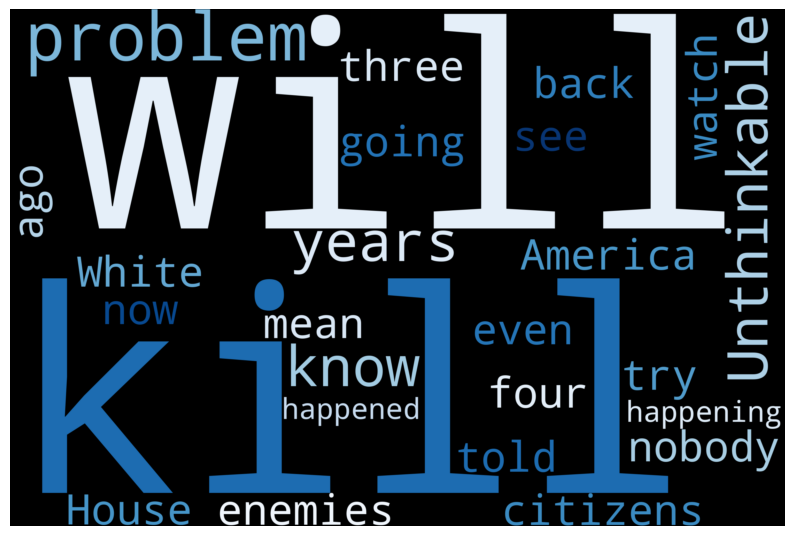

In [12]:
# Function untuk menampilkan wordcloud
def plot_cloud(wordcloud):
    plt.figure(figsize=[10, 8])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# gabungkan semua text menjadi 1 string
all_text = ' '.join(list_hasil_transkrip)

# membuat word cloud
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    random_state = 3,
    background_color = 'black',
    colormap = 'Blues_r',
    collocations = False,
).generate(all_text)

# tampilkan wordcloudnya
plot_cloud(wordcloud)

In [116]:
input_data = list_hasil_transkrip

In [117]:
# Vectorize setiap input text pada list
vectorized_texts = [vectorizer(text) for text in input_data]

# # Pad sequence dengan panjang yg sa,a
padded_texts = tf.keras.preprocessing.sequence.pad_sequences(vectorized_texts, maxlen=1800)

In [118]:
# predictions = model.predict(vectorized_texts)
predictions = model.predict(padded_texts)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


In [119]:
predictions

array([[2.38095030e-01, 2.14918880e-04, 1.32651525e-02, 1.78835362e-01,
        2.11702622e-02, 4.53145895e-03],
       [7.70449340e-02, 7.94449377e-08, 6.71954080e-03, 6.09895855e-04,
        9.64459497e-03, 1.41859316e-04],
       [1.79522365e-01, 2.26002453e-06, 1.59715712e-02, 1.46017456e-03,
        3.15272920e-02, 5.23124530e-04],
       [9.97488797e-01, 1.01877995e-01, 4.41394866e-01, 9.03899789e-01,
        7.09758282e-01, 9.27637592e-02],
       [3.35166484e-01, 4.56353655e-06, 1.11212954e-02, 5.82993089e-04,
        4.60479558e-02, 4.15553193e-04],
       [2.17092410e-02, 5.98908534e-10, 1.38425734e-03, 2.68288597e-04,
        2.70893425e-03, 4.08326596e-05]], dtype=float32)

In [120]:
binary_predictions = (predictions > 0.5).astype(int)
binary_predictions

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [121]:
# Print predictions
for i, text in enumerate(input_data):
    print("Text:", text)
    for label, pred in zip(labels, binary_predictions[i]):
        print(f"{label}: {pred}")
    print()

Text: when I'm back in the White House America's enemies will now once again
toxic: 0
sangat_toxic: 0
cabul: 0
ancaman: 0
penghinaan: 0
rasis: 0

Text:  and they're going to know it
toxic: 0
sangat_toxic: 0
cabul: 0
ancaman: 0
penghinaan: 0
rasis: 0

Text:  that if you try to
toxic: 0
sangat_toxic: 0
cabul: 0
ancaman: 0
penghinaan: 0
rasis: 0

Text:  kill our citizens we will kill you we will kill you
toxic: 1
sangat_toxic: 0
cabul: 0
ancaman: 1
penghinaan: 1
rasis: 0

Text:  I told them all that we had no problem
toxic: 0
sangat_toxic: 0
cabul: 0
ancaman: 0
penghinaan: 0
rasis: 0

Text:  you know we had no problem three years ago we had no problem for four years nobody even this is Unthinkable I mean I just watch and see what's happening it's Unthinkable this couldn't have happened
toxic: 0
sangat_toxic: 0
cabul: 0
ancaman: 0
penghinaan: 0
rasis: 0



In [122]:
total_predictions = binary_predictions.sum(axis=0)
total_predictions

array([1, 0, 0, 1, 1, 0])

In [123]:
for i, (label, total) in enumerate(zip(labels, total_predictions)):
    print(f"{label}: {total}")

toxic: 1
sangat_toxic: 0
cabul: 0
ancaman: 1
penghinaan: 1
rasis: 0


In [124]:
label_index = {label: [] for label in labels}

total_predictions = binary_predictions.sum(axis=0)

for i, (prediction, text) in enumerate(zip(binary_predictions, input_data)):
    for j, (label, pred) in enumerate(zip(labels, prediction)):
        if pred == 1:
            print(f"Text: {text}")
            print(f"Prediction: {label} \nAkurasi Prediksi: {predictions[i][j]}")
            label_index[label].append(i)  # Simpan index yang labelnya terdeteksi 1
            print()

print('\n')
for label, total in zip(labels, total_predictions):
    print(f"Total {label} predictions: {total}")
    print(f"Index Kalimat yang terdeteksi {label}: {label_index[label]}")
    print()

Text:  kill our citizens we will kill you we will kill you
Prediction: toxic 
Akurasi Prediksi: 0.997488796710968

Text:  kill our citizens we will kill you we will kill you
Prediction: ancaman 
Akurasi Prediksi: 0.9038997888565063

Text:  kill our citizens we will kill you we will kill you
Prediction: penghinaan 
Akurasi Prediksi: 0.7097582817077637



Total toxic predictions: 1
Index Kalimat yang terdeteksi toxic: [3]

Total sangat_toxic predictions: 0
Index Kalimat yang terdeteksi sangat_toxic: []

Total cabul predictions: 0
Index Kalimat yang terdeteksi cabul: []

Total ancaman predictions: 1
Index Kalimat yang terdeteksi ancaman: [3]

Total penghinaan predictions: 1
Index Kalimat yang terdeteksi penghinaan: [3]

Total rasis predictions: 0
Index Kalimat yang terdeteksi rasis: []



# Cleaning List

In [77]:
input_data = list_hasil_transkrip

In [78]:
def normalize_text(text):
    text = text.lower()  # Ubah menjadi huruf kecil
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"there's", "there is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"who's", "who is", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"ain't", "are not", text)
    text = re.sub(r"ive", "i have", text)
    text = re.sub(r"ok", "okay", text)
    text = re.sub(r"they're", "they are", text)
    return text

In [79]:
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9_]+','',text) # Hapus mention
    text = re.sub(r'#\w+','',text) # Hapus hashtag
    text = re.sub(r'RT[\s]+','',text) # Hapus retweet
    text = re.sub(r'https?://\S+','',text) # Hapus url
    text = re.sub(r'\r\n', ' ', text)  # Mengubah \r\n menjadi spasi
    text = re.sub(r'\r|\n', ' ', text) # Hapus karakter escape seperti \r dan \n
    text = re.sub(r'[^A-Za-z0-9 ]','',text) # Hapus karakter non alpha numeric
    text = re.sub(r'\d+', '', text) # hapus angka
    text = re.sub(r'\s+',' ',text).strip() # Hapus spasi berlebih

    return text

In [80]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [81]:
# Inisialisasi stopwords dan lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = normalize_text(text)  # Normalisasi teks
    text = clean_text(text)  # Bersihkan teks
    
    # stopwords dan lemmatize
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

In [82]:
clean_input = [preprocess_text(text) for text in input_data]
# clean_input = preprocess_text(all_text)

# if input_data:
#     clean_input = [preprocess_text(text) for text in input_data]
# elif input_data_text:
#     clean_input = preprocess_text(input_data_text)

In [83]:
clean_input

['back white house america enemy',
 'going know',
 'try',
 'kill citizen kill kill',
 'told problem',
 'know problem three year ago problem four year nobody even unthinkable mean watch see happening unthinkable could happened']

In [84]:
# Vectorize setiap input text pada list
# vectorized_texts = vectorizer([all_text])
# vectorized_texts = vectorizer([clean_input])
vectorized_texts = [vectorizer(text) for text in clean_input]
# vectorized_texts = [vectorizer(text) for text in input_data]

# # Pad sequence dengan panjang yg sa,a
padded_texts = tf.keras.preprocessing.sequence.pad_sequences(vectorized_texts, maxlen=1800)

In [85]:
# predictions = model.predict(vectorized_texts)
predictions = model.predict(padded_texts)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


In [86]:
binary_predictions = (predictions > 0.5).astype(int)
binary_predictions

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [87]:
# Print predictions
for i, text in enumerate(input_data):
    print("Text:", text)
    for label, pred in zip(labels, binary_predictions[i]):
        print(f"{label}: {pred}")
    print()

Text: when I'm back in the White House America's enemies will now once again
toxic: 0
sangat_toxic: 0
cabul: 0
ancaman: 0
penghinaan: 0
rasis: 0

Text:  and they're going to know it
toxic: 0
sangat_toxic: 0
cabul: 0
ancaman: 0
penghinaan: 0
rasis: 0

Text:  that if you try to
toxic: 0
sangat_toxic: 0
cabul: 0
ancaman: 0
penghinaan: 0
rasis: 0

Text:  kill our citizens we will kill you we will kill you
toxic: 1
sangat_toxic: 0
cabul: 1
ancaman: 1
penghinaan: 1
rasis: 0

Text:  I told them all that we had no problem
toxic: 0
sangat_toxic: 0
cabul: 0
ancaman: 0
penghinaan: 0
rasis: 0

Text:  you know we had no problem three years ago we had no problem for four years nobody even this is Unthinkable I mean I just watch and see what's happening it's Unthinkable this couldn't have happened
toxic: 0
sangat_toxic: 0
cabul: 0
ancaman: 0
penghinaan: 0
rasis: 0



In [88]:
total_predictions = binary_predictions.sum(axis=0)
total_predictions

array([1, 0, 1, 1, 1, 0])

In [89]:
for i, (label, total) in enumerate(zip(labels, total_predictions)):
    print(f"{label}: {total}")

toxic: 1
sangat_toxic: 0
cabul: 1
ancaman: 1
penghinaan: 1
rasis: 0


In [90]:
label_index = {label: [] for label in labels}

total_predictions = binary_predictions.sum(axis=0)

for i, (prediction, text) in enumerate(zip(binary_predictions, input_data)):
    for j, (label, pred) in enumerate(zip(labels, prediction)):
        if pred == 1:
            print(f"Text: {text}")
            print(f"Prediction: {label} \nAkurasi Prediksi: {predictions[i][j]}")
            label_index[label].append(i)  # Simpan index yang labelnya terdeteksi 1
            print()

print('\n')
for label, total in zip(labels, total_predictions):
    print(f"Total {label} predictions: {total}")
    print(f"Index Kalimat yang terdeteksi {label}: {label_index[label]}")
    print()

Text:  kill our citizens we will kill you we will kill you
Prediction: toxic 
Akurasi Prediksi: 0.9970459342002869

Text:  kill our citizens we will kill you we will kill you
Prediction: cabul 
Akurasi Prediksi: 0.601630687713623

Text:  kill our citizens we will kill you we will kill you
Prediction: ancaman 
Akurasi Prediksi: 0.7724084854125977

Text:  kill our citizens we will kill you we will kill you
Prediction: penghinaan 
Akurasi Prediksi: 0.5338108539581299



Total toxic predictions: 1
Index Kalimat yang terdeteksi toxic: [3]

Total sangat_toxic predictions: 0
Index Kalimat yang terdeteksi sangat_toxic: []

Total cabul predictions: 1
Index Kalimat yang terdeteksi cabul: [3]

Total ancaman predictions: 1
Index Kalimat yang terdeteksi ancaman: [3]

Total penghinaan predictions: 1
Index Kalimat yang terdeteksi penghinaan: [3]

Total rasis predictions: 0
Index Kalimat yang terdeteksi rasis: []



# Cleaning String

In [91]:
# gabungkan semua text menjadi 1 string
all_text = ' '.join(list_hasil_transkrip)

In [92]:
all_text

"when I'm back in the White House America's enemies will now once again  and they're going to know it  that if you try to  kill our citizens we will kill you we will kill you  I told them all that we had no problem  you know we had no problem three years ago we had no problem for four years nobody even this is Unthinkable I mean I just watch and see what's happening it's Unthinkable this couldn't have happened"

In [93]:
clean_input = preprocess_text(all_text)

In [94]:
clean_input

'back white house america enemy going know try kill citizen kill kill told problem know problem three year ago problem four year nobody even unthinkable mean watch see happening unthinkable could happened'

In [95]:
vectorized_texts = vectorizer([clean_input])

# # Pad sequence dengan panjang yg sa,a
padded_texts = tf.keras.preprocessing.sequence.pad_sequences(vectorized_texts, maxlen=1800)

In [96]:
# predictions = model.predict(vectorized_texts)
predictions = model.predict(padded_texts)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


In [97]:
binary_predictions = (predictions > 0.5).astype(int)
binary_predictions

array([[1, 0, 0, 1, 1, 0]])

In [99]:
total_predictions = binary_predictions.sum(axis=0)
total_predictions

array([1, 0, 0, 1, 1, 0])

In [100]:
for i, (label, total) in enumerate(zip(labels, total_predictions)):
    print(f"{label}: {total}")

toxic: 1
sangat_toxic: 0
cabul: 0
ancaman: 1
penghinaan: 1
rasis: 0


In [110]:
predictions

array([[0.9923132 , 0.0400334 , 0.30770442, 0.8979833 , 0.6177306 ,
        0.0227885 ]], dtype=float32)

In [109]:
# Menampilkan teks input
print("Teks Input:", all_text)
print()

# Menampilkan hasil prediksi untuk setiap label yang bernilai 1
for i, (label, prediction_value) in enumerate(zip(labels, predictions[0])):
    binary_value = binary_predictions[0][i]
    if binary_value == 1:
        print(f"Label: {label}")
        print(f"Prediksi: {binary_value}")
        print(f"Akurasi Prediksi: {prediction_value:}")
        print()

Teks Input: when I'm back in the White House America's enemies will now once again  and they're going to know it  that if you try to  kill our citizens we will kill you we will kill you  I told them all that we had no problem  you know we had no problem three years ago we had no problem for four years nobody even this is Unthinkable I mean I just watch and see what's happening it's Unthinkable this couldn't have happened

Label: toxic
Prediksi: 1
Akurasi Prediksi: 0.9923132061958313

Label: ancaman
Prediksi: 1
Akurasi Prediksi: 0.8979833126068115

Label: penghinaan
Prediksi: 1
Akurasi Prediksi: 0.6177306175231934

